In [2]:
#import libraries
import os,sys
import subprocess
import numpy as np
import qiskit as qk
from qiskit import Aer, IBMQ, execute
from qiskit.tools import job_monitor
import matplotlib.pyplot as plt

In [3]:
#instantiate IBM quantum simulator
qasm_sim = Aer.get_backend('qasm_simulator')

In [4]:
#Define post-processing function to get magentization from quantum simulator results
def average_magnetization(result: dict, shots: int):
    """Compute average magnetization from results of qk.execution.
    Args:
    - result (dict): a dictionary with the counts for each qubit, see qk.result.result module
    - shots (int): number of trials
    Return:
    - average_mag (float)
      """
    mag = 0
    for spin_str, count in result.items():
        spin_int = [1 - 2 * float(s) for s in spin_str]
        mag += (sum(spin_int) / len(spin_int)) * count
    average_mag = mag / shots
    return average_mag

In [5]:
#Define simulation parameters
N = 5 #number of spins/qubits
shots = 8192 #number of shots for circuit execution

In [6]:
#Generate compressed circuits corresponding to red curve
num_steps = 1200
dt = 0.05
time_ax1 = []
for step in range(num_steps):
    time_ax1.append(dt*step)

input_fname = f'TFIM_adiabatic_nsteps{num_steps}.ini'
subprocess.run(["../../release/examples/f3c_time_evolution_TFXY", input_fname])

CompletedProcess(args=['../../release/examples/f3c_time_evolution_TFXY', 'TFIM_adiabatic_nsteps1200.ini'], returncode=0)

In [7]:
#prepare compressed circuits to run on quantum backends
q_regs = qk.QuantumRegister(N, 'q')
c_regs = qk.ClassicalRegister(N, 'c')
compressed_circuits = []
for step in range(1,num_steps+1):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #get constant-depth evolution circuit
    fname = f'TFIM_timestep{step}.qasm'
    circ = qk.QuantumCircuit.from_qasm_file(fname)
    total_circ.compose(circ, inplace=True)
    total_circ.measure(q_regs, c_regs)
    compressed_circuits.append(total_circ)

In [8]:
#Run compressed circuits on quantum simulator
compressed_sim_job = execute(compressed_circuits, backend=qasm_sim, shots=shots)
job_monitor(compressed_sim_job)
compressed_sim_results = compressed_sim_job.result()

Job Status: job has successfully run


In [9]:
#Post-processing for compressed circuit results from quantum simulator
mags_nsteps1200 = []
compressed_sim_counts = compressed_sim_results.get_counts()
for t in range(num_steps):
    mag = average_magnetization(compressed_sim_counts[t], shots)
    mags_nsteps1200.append(mag)

In [10]:
#Generate compressed circuits corresponding to purple curve
num_steps = 240
dt = 0.25
time_ax2 = []
for step in range(num_steps):
    time_ax2.append(dt*step)

input_fname = f'TFIM_adiabatic_nsteps{num_steps}.ini'
subprocess.run(["../../release/examples/f3c_time_evolution_TFXY", input_fname])

CompletedProcess(args=['../../release/examples/f3c_time_evolution_TFXY', 'TFIM_adiabatic_nsteps240.ini'], returncode=0)

In [11]:
#prepare compressed circuits to run on quantum backends
q_regs = qk.QuantumRegister(N, 'q')
c_regs = qk.ClassicalRegister(N, 'c')
compressed_circuits = []
for step in range(1,num_steps+1):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #get constant-depth evolution circuit
    fname = f'TFIM_timestep{step}.qasm'
    circ = qk.QuantumCircuit.from_qasm_file(fname)
    total_circ.compose(circ, inplace=True)
    total_circ.measure(q_regs, c_regs)
    compressed_circuits.append(total_circ)

In [12]:
#Run compressed circuits on quantum simulator
compressed_sim_job = execute(compressed_circuits, backend=qasm_sim, shots=shots)
job_monitor(compressed_sim_job)
compressed_sim_results = compressed_sim_job.result()

Job Status: job has successfully run


In [13]:
#Post-processing for compressed circuit results from quantum simulator
mags_nsteps240 = []
compressed_sim_counts = compressed_sim_results.get_counts()
for t in range(num_steps):
    mag = average_magnetization(compressed_sim_counts[t], shots)
    mags_nsteps240.append(mag)

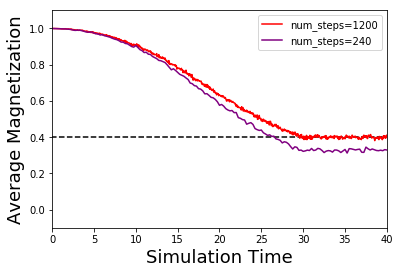

In [14]:
#Plot magnetizations
plt.plot(time_ax1, mags_nsteps1200, color='r', label="num_steps=1200")
plt.plot(time_ax2, mags_nsteps240, color='purple', label="num_steps=240")
plt.hlines(0.4031775, -0.1, 40, linestyle="dashed", color="k")
plt.xlim(0,40)
plt.ylim(-0.1, 1.1)
plt.xlabel('Simulation Time', fontsize=18)
plt.ylabel('Average Magnetization', fontsize=18)
plt.legend()
plt.show()